In [208]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### dataset preparation

The token we work with is a single character (for simplicity).
Our model will train to predict next token given previous context of 3 tokens (3-grams)

In [223]:
# read names
with open("names.txt", "r") as fnames:
    names = fnames.read().splitlines()
names_cnt = len(names)
print('names:')
for name in names[:5]:
    print(name)
print(f'total names count: {names_cnt}')

# building vocabulary
special_tokens = ['.'] # represents the start and the end of each name.
vocab = special_tokens + sorted(list(set(''.join(names))))
vocab_size = len(vocab)
print(f'{vocab=}')
print(f'{vocab_size=}')

# mapping from chars to token number and vice-versa
ctoi = {c:i for i,c in enumerate(vocab)}
itoc = vocab
encode = lambda char_seq: [ctoi[c] for c in char_seq]
decode = lambda token_num_seq: [itoc[t] for t in token_num_seq]
print(encode("vlad"), decode([22,12,1,4]))

# prepare dataset for NN training and validation
block_size = 3 # represents the length of context
def build_dataset(names):
    X, y = [], []
    for name in names:
        block = torch.zeros(block_size).to(torch.int64)
        for c in name + '.':
            ix = ctoi[c]
            X.append(block)
            y.append(ix)
            block = block.roll(-1)
            block[-1] = ix
    X, y = torch.stack(X), torch.tensor(y)
    return X, y

#train/validation/test split
random.shuffle(names)
train_bound = int(0.8*names_cnt)
val_bound   = int(0.9*names_cnt)
train_X, train_y = build_dataset(names[:train_bound])
val_X, val_y = build_dataset(names[train_bound:val_bound])
test_X, test_y = build_dataset(names[val_bound:])
print(f'{train_X.shape=}, {train_y.shape=}, {val_X.shape=}, {val_y.shape=}, {test_X.shape=}, {test_y.shape=}')
print("train:")
for i in range(13):
    print(f'{"".join(decode(train_X[i]))} => {itoc[train_y[i]]}')
print("val:")
for i in range(13):
    print(f'{"".join(decode(val_X[i]))} => {itoc[val_y[i]]}')
print("test:")
for i in range(13):
    print(f'{"".join(decode(test_X[i]))} => {itoc[test_y[i]]}')

names:
emma
olivia
ava
isabella
sophia
total names count: 32033
vocab=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab_size=27
[22, 12, 1, 4] ['v', 'l', 'a', 'd']
X.shape=torch.Size([182681, 3]), y.shape=torch.Size([182681])
X.shape=torch.Size([22589, 3]), y.shape=torch.Size([22589])
X.shape=torch.Size([22876, 3]), y.shape=torch.Size([22876])
train_X.shape=torch.Size([182681, 3]), train_y.shape=torch.Size([182681]), val_X.shape=torch.Size([22589, 3]), val_y.shape=torch.Size([22589]), test_X.shape=torch.Size([22876, 3]), test_y.shape=torch.Size([22876])
train:
... => j
..j => e
.je => i
jei => l
eil => y
ily => n
lyn => .
... => r
..r => y
.ry => z
ryz => e
yze => .
... => k
val:
... => i
..i => s
.is => h
ish => m
shm => a
hma => e
mae => l
ael => .
... => a
..a => d
.ad => r
adr => i
dri => e
test:
... => k
..k => r
.kr => o
kro => s
ros => s
oss => .
... => c
..c => l
.cl => a
cla => r
lar =>

### Define training loop and Evaluation method

In [278]:
def train(model, train_X, train_y, val_X, val_y, epoches, batch_size, lr=1e-3):
    train_loss, val_loss = [], []
    for epoch in range(epoches):
        ids = torch.randperm(train_X.shape[0])
        cur_losses = []
        for batch_ids_lb in range(0, train_X.shape[0], batch_size):
            batch_ids = ids[batch_ids_lb:batch_ids_lb+batch_size]
            mini_batch_X = train_X[batch_ids].to(device)
            mini_batch_y = train_y[batch_ids].to(device)
            logits = model(mini_batch_X)
            loss = F.cross_entropy(logits, mini_batch_y)
            cur_losses.append(loss.item())
            model.zero_grad()
            loss.backward()
            model.optimize(lr = lr)
        cur_avg_train_loss = sum(cur_losses) / len(cur_losses)
        cur_val_loss = F.cross_entropy(model(val_X), val_y).item()
        print(f'{epoch=}: {cur_avg_train_loss=}, {cur_val_loss=}')
        train_loss.append(cur_avg_train_loss)
        val_loss.append(cur_val_loss)
    return train_loss, val_loss


@torch.no_grad()
def evaluate(model, max_new_tokens=100):
    result = []
    context = torch.zeros((1, block_size)).to(torch.int64)
    for t in range(max_new_tokens):
        next_token = torch.multinomial(F.softmax(model(context), dim=1), 1)
        result.append(next_token)
        if next_token == 0:
            break
        context = context.roll(-1, dims=1)
        context[0, -1] = next_token
    return result

### Build multi-layer perceptron (MLP) model

here we are building something like "Bengio et al. 2003 A Neural Probabilistic Language Model" paper

In [246]:
class MLP:
    def __init__(self, vocab_size, block_size, emb_size, hidden_size, device='cpu'):
        self.context_size = block_size*emb_size
        self.emb = torch.randn((vocab_size, emb_size), requires_grad = True, device = device)
        self.W1 = torch.randn((self.context_size, hidden_size), requires_grad = True, device = device)
        self.b1 = torch.randn(hidden_size, requires_grad = True, device = device)
        self.W2 = torch.randn((hidden_size, vocab_size), requires_grad = True, device = device)
        self.b2 = torch.randn(vocab_size, requires_grad = True, device = device)
    
    def forward(self, mini_batch_X):
        embeddings  = self.emb[mini_batch_X]
        concat_embs = embeddings.view(-1, self.context_size)
        out1 = concat_embs @ self.W1 + self.b1
        out1 = F.tanh(out1)
        out2 = out1 @ self.W2 + self.b2
        return out2

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def optimize(self, lr):
        for p in self.parameters():
            p.data -= lr*p.grad

    def parameters(self):
        return [self.emb, self.W1, self.b1, self.W2, self.b2]

    def nelement(self):
        return sum(p.nelement() for p in self.parameters())

    def __call__(self, mini_batch_X):
        return self.forward(mini_batch_X)

model.nelement()=4433
epoch=0: cur_avg_train_loss=2.7666857048007945, cur_val_loss=2.7125062942504883
epoch=1: cur_avg_train_loss=2.5164856500675716, cur_val_loss=2.525550603866577
epoch=2: cur_avg_train_loss=2.4825586249239597, cur_val_loss=2.4961893558502197
epoch=3: cur_avg_train_loss=2.457539295983189, cur_val_loss=2.455648183822632
epoch=4: cur_avg_train_loss=2.4427207526726398, cur_val_loss=2.479430913925171
epoch=5: cur_avg_train_loss=2.4315096380414145, cur_val_loss=2.4662413597106934
epoch=6: cur_avg_train_loss=2.421716611731908, cur_val_loss=2.4478588104248047
epoch=7: cur_avg_train_loss=2.414546715231994, cur_val_loss=2.4781136512756348
epoch=8: cur_avg_train_loss=2.40948101572314, cur_val_loss=2.4799885749816895
epoch=9: cur_avg_train_loss=2.401956712343647, cur_val_loss=2.4142191410064697
epoch=10: cur_avg_train_loss=2.39661434648751, cur_val_loss=2.4618091583251953
epoch=11: cur_avg_train_loss=2.3904594021377963, cur_val_loss=2.4366424083709717
epoch=12: cur_avg_train_los

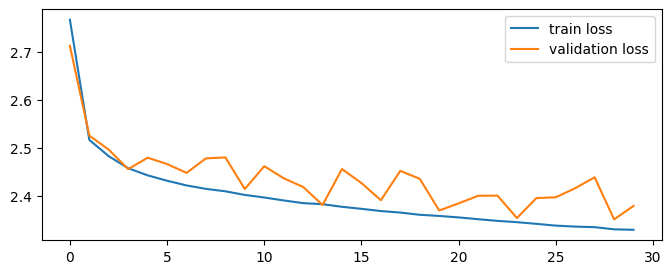

In [251]:
model = MLP(vocab_size, block_size, emb_size=2, hidden_size=128, device=device)
print(f'{model.nelement()=}')
train_loss, val_loss = train(model, train_X, train_y, val_X.to(device), val_y.to(device), epoches=30, batch_size=64, lr=0.1)
plt.figure(figsize=(8,3))
plt.plot(np.array(train_loss), label = 'train loss')
plt.plot(np.array(val_loss), label = 'validation loss')
plt.legend()

In [253]:
for i in range(10):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

aly.
mirion.
brinjitk.
aubariya.
dyun.
son.
mrangh.
kee.
vau.
bloaz.


### Visualize 2D embeddings

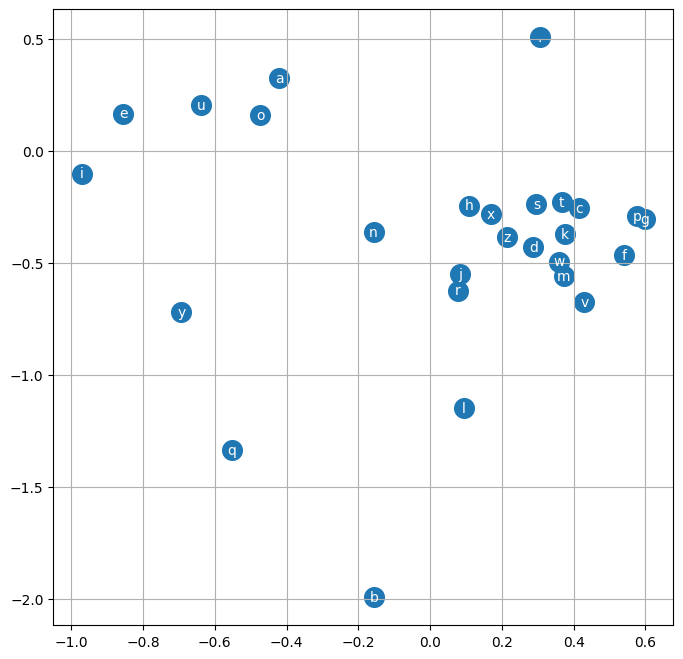

In [260]:
# visualize dimensions 0 and 1 of the embedding matrix model.emb for all characters
plt.figure(figsize=(8,8))
C = model.emb.cpu()
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

### Scale-up the model

model384.nelement()=22569
epoch=0: cur_avg_train_loss=4.537107204180048, cur_val_loss=3.3436193466186523
epoch=1: cur_avg_train_loss=2.8663437752297796, cur_val_loss=2.984354019165039
epoch=2: cur_avg_train_loss=2.697152230284469, cur_val_loss=3.1005892753601074
epoch=3: cur_avg_train_loss=2.6289448362724586, cur_val_loss=2.908522605895996
epoch=4: cur_avg_train_loss=2.5842694454560555, cur_val_loss=2.7352471351623535
epoch=5: cur_avg_train_loss=2.551323105491398, cur_val_loss=2.6226818561553955
epoch=6: cur_avg_train_loss=2.5272387639027345, cur_val_loss=2.7434778213500977
epoch=7: cur_avg_train_loss=2.507199018097592, cur_val_loss=2.6827163696289062
epoch=8: cur_avg_train_loss=2.492223301827386, cur_val_loss=2.7193729877471924
epoch=9: cur_avg_train_loss=2.4761044017905323, cur_val_loss=2.683624744415283
epoch=10: cur_avg_train_loss=2.4687238843553745, cur_val_loss=2.7304656505584717
epoch=11: cur_avg_train_loss=2.4529719223700557, cur_val_loss=2.709752082824707
epoch=12: cur_avg_tra

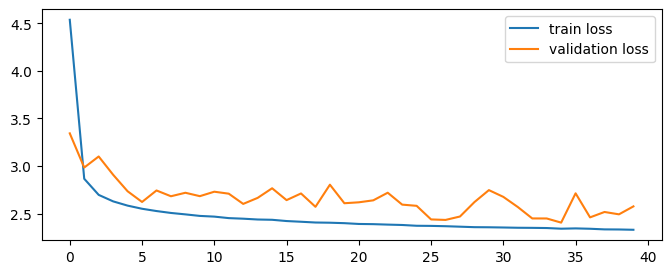

In [271]:
model384 = MLP(vocab_size, block_size, emb_size=10, hidden_size=384, device=device)
print(f'{model384.nelement()=}')
train_loss, val_loss = train(model384, train_X, train_y, val_X.to(device), val_y.to(device), epoches=40, batch_size=64, lr=0.1)

plt.figure(figsize=(8,3))
plt.plot(np.array(train_loss), label = 'train loss')
plt.plot(np.array(val_loss), label = 'validation loss')
plt.legend()

In [272]:
for i in range(10):
    print(''.join(decode(evaluate(model384, max_new_tokens=1000))))

bro.
cene.
dechennediaigenii.
kesia.
ebaishaureytani.
kenduadhariaei.
eddajiha.
keya.
charidenahishahiree.
jenevedyn.


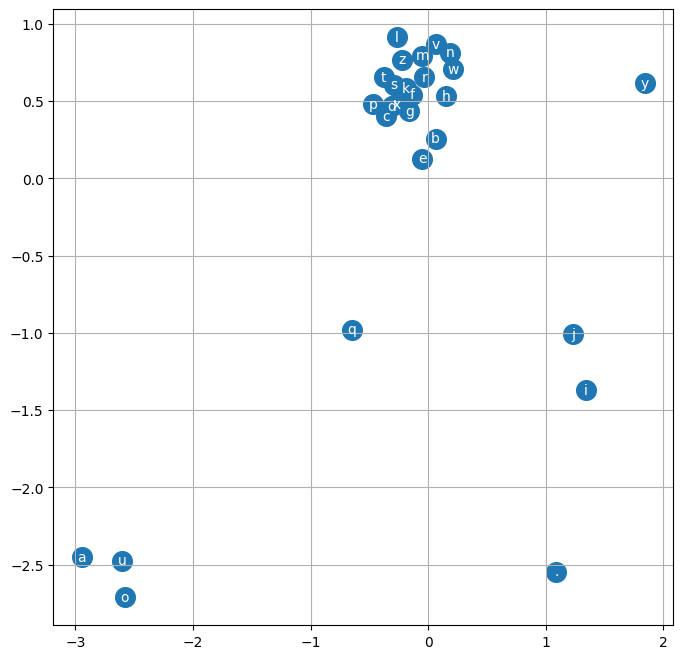

In [273]:
# visualize some 2 dimensions of the embedding matrix model384.emb for all characters
plt.figure(figsize=(8,8))
C = model384.emb.cpu()
dim1, dim2 = 4, 5
plt.scatter(C[:, dim1].data, C[:, dim2].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, dim1].item(), C[i, dim2].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

### Test evaluation

In [277]:
with torch.no_grad():
    test_logits = model384(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(test_loss)

tensor(2.5710)


### Build pyTorch-like classes and model

In [540]:
from functools import reduce
class Linear:
    def __init__(self, in_features, out_features, bias=True, device='cpu', dtype=torch.float32, gen=None):
        self.W = torch.randn([in_features, out_features], dtype=dtype, device=device, generator=gen)
        self.b = torch.randn(out_features, dtype=dtype, device=device, generator=gen) if bias else None

    def __call__(self, X):
        self.out = X @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def nelement(self):
        return sum(self.parameters())


class Tanh():
    def __call__(self, X):
        self.out = torch.tanh(X)
        return self.out

    def parameters(self):
        return []


class MultiLayerPerceptron:
    def __init__(self, vocab_size, block_size, n_emb, n_hidden, device='cpu', gen=None):
        self.context_size = n_emb * block_size
        self.emb_table = torch.randn((vocab_size, n_emb), device=device, generator=gen)
        self.layers = [
            Linear(self.context_size, n_hidden, device=device, gen=gen), Tanh(),
            Linear(n_hidden, n_hidden, device=device, gen=gen), Tanh(),
            Linear(n_hidden, n_hidden, device=device, gen=gen), Tanh(),
            Linear(n_hidden, n_hidden, device=device, gen=gen), Tanh(),
            Linear(n_hidden, vocab_size, device=device, gen=gen)
        ]
        for p in self.parameters():
            p.requires_grad = True

    def __call__(self, X):
        emb = self.emb_table[X].view(-1, self.context_size)
        return reduce(lambda out, L: L(out), self.layers, emb)

    def parameters(self):
        return [self.emb_table] + [p for layer in self.layers for p in layer.parameters()]

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def nelement(self):
        return sum(p.nelement() for p in self.parameters())

    def retain_grad(self):
        for L in self.layers:
            L.out.retain_grad()


class SgdOptimizer:
    def __init__(self, parameters, learning_rate_provider):
        self.parameters = parameters
        self.lr_provider = learning_rate_provider
        self.update_data_ratio = []

    def step(self):
        lr = self.lr_provider.get()
        for p in self.parameters:
            p.data -= lr*p.grad
        with torch.no_grad():
            self.update_data_ratio.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in self.parameters])

class ConstatntLr:
    def __init__(self, lr):
        self.lr = lr

    def get(self):
        return self.lr

class TensorDataset:
    def __init__(self, X, y, device='cpu'):
        self.X = X.to(device)
        self.y = y.to(device)
        self.ids = list(range(X.shape[0]))
        self.l_bord = 0

    def reshuffle(self):
        random.shuffle(self.ids)
        self.l_bord = 0

    def is_processed(self):
        return self.l_bord >= self.X.shape[0]

    def get_mini_batch(self, batch_size, device='cpu'):
        if self.is_processed():
            print("Warning. Current shuffle is processed. Reshuffling...")
            self.reshuffle()
        batch_ids = self.ids[self.l_bord:self.l_bord+batch_size]
        if len(batch_ids) < batch_size:
            k = batch_size - len(batch_ids)
            extra_ids = random.sample(range(self.l_bord), k)
            batch_ids.extend(extra_ids)
        mini_batch_X = train_X[batch_ids].to(device)
        mini_batch_y = train_y[batch_ids].to(device)
        self.l_bord += batch_size
        return mini_batch_X, mini_batch_y

### new training loop

In [541]:
def train_step(model, mini_batch_X, mini_batch_y, optimizer):
    logits = model(mini_batch_X)
    loss = F.cross_entropy(logits, mini_batch_y)
    model.retain_grad()
    model.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def train2(model, train_dataset, val_dataset, epoches, batch_size, optimizer):
    train_loss, val_loss = [], []
    for epoch in range(epoches):
        train_dataset.reshuffle()
        cur_losses = []
        while not train_dataset.is_processed():
            mini_batch_X, mini_batch_y = train_dataset.get_mini_batch(batch_size, device)
            loss = train_step(model, mini_batch_X, mini_batch_y, optimizer)
            cur_losses.append(loss.item())
        cur_avg_train_loss = sum(cur_losses) / len(cur_losses)
        cur_val_loss = F.cross_entropy(model(val_dataset.X), val_dataset.y).item()
        print(f'{epoch=}: {cur_avg_train_loss=}, {cur_val_loss=}')
        train_loss.append(cur_avg_train_loss)
        val_loss.append(cur_val_loss)
    return train_loss, val_loss

### Activations visualizations

In [542]:
# visualize histograms
def plot_forward_activations(model, layer_type=None):
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(model.layers):
        if isinstance(layer, layer_type):
            t = layer.out.to('cpu')
            saturation = (t.abs() > 0.97).float().mean()*100
            layer_name = layer.__class__.__name__
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer_name, t.mean(), t.std(), saturation))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')


def plot_backward_gradients(model, layer_type=None):
    plt.figure(figsize=(20, 4))
    legends = []
    for i, layer in enumerate(model.layers):
        if isinstance(layer, layer_type):
            t = layer.out.grad.to('cpu')
            layer_name = layer.__class__.__name__
            print('layer %d (%10s): mean %+f, std %e' % (i, layer_name, t.mean(), t.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('gradient distribution')


def visualize_weights_gradients(model):
    plt.figure(figsize=(20, 4))
    legends = []
    for i,p in enumerate(model.parameters()):
        t = p.grad.to('cpu')
        if p.ndim == 2:
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution');


def visualize_gradient_to_weight_ratio(optimizer):
    plt.figure(figsize=(20, 4))
    legends = []
    ud = optimizer.update_data_ratio
    for i,p in enumerate(optimizer.parameters):
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)
    plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
    plt.legend(legends);

model.nelement()=57257
init_t_loss=24.352346420288086, init_v_loss=24.18595314025879
layer 1 (      Tanh): mean +0.02, std 0.92, saturated: 67.68%
layer 3 (      Tanh): mean +0.00, std 0.96, saturated: 84.54%
layer 5 (      Tanh): mean -0.01, std 0.96, saturated: 84.05%
layer 7 (      Tanh): mean -0.01, std 0.96, saturated: 84.82%


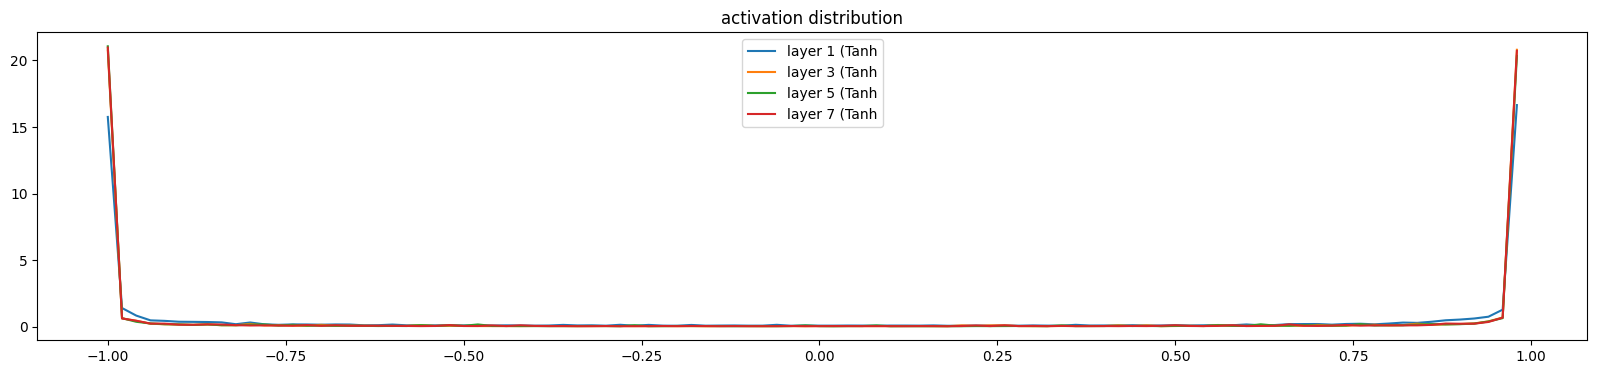

In [543]:
g = torch.Generator(device=device).manual_seed(7877)

train_ds = TensorDataset(train_X, train_y)
val_ds   = TensorDataset(val_X, val_y, device)

model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")
plot_forward_activations(model, layer_type=Tanh)

#### Given the plot above we see that randomly initialized weights produce almost saturated tanh activations, so gradient signal on backward pass will be to small to learn effectively.

layer 1 (      Tanh): mean +0.010100, std 3.210429e-01
layer 3 (      Tanh): mean -0.000151, std 1.282860e-01
layer 5 (      Tanh): mean -0.000765, std 4.817660e-02
layer 7 (      Tanh): mean +0.000327, std 2.034999e-02


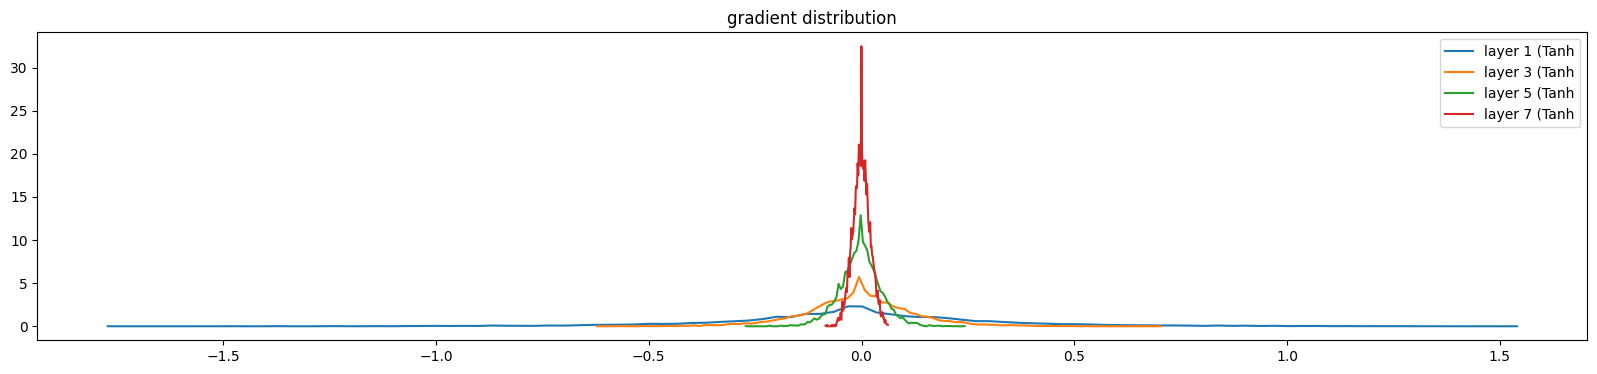

In [544]:
mb_X, mb_y = train_ds.get_mini_batch(64, device)
train_step(model, mb_X, mb_y, optimizer)
plot_backward_gradients(model, Tanh)

#### On the plot above we see the spreading of gradient distribution from last to very first layer (as a result of saturated tanh). It makes first layers difficult to learn as they get small gradient signal. It is called 'gradient vanishing'

weight   (27, 10) | mean -0.177626 | std 4.238103e+00 | grad:data ratio 4.206956e+00
weight  (30, 128) | mean -0.019062 | std 1.138505e+00 | grad:data ratio 1.154423e+00
weight (128, 128) | mean +0.000429 | std 3.270231e-01 | grad:data ratio 3.235153e-01
weight (128, 128) | mean +0.001514 | std 1.338918e-01 | grad:data ratio 1.331834e-01
weight (128, 128) | mean +0.000085 | std 4.425577e-02 | grad:data ratio 4.408982e-02
weight  (128, 27) | mean -0.000000 | std 4.282732e-02 | grad:data ratio 4.368010e-02


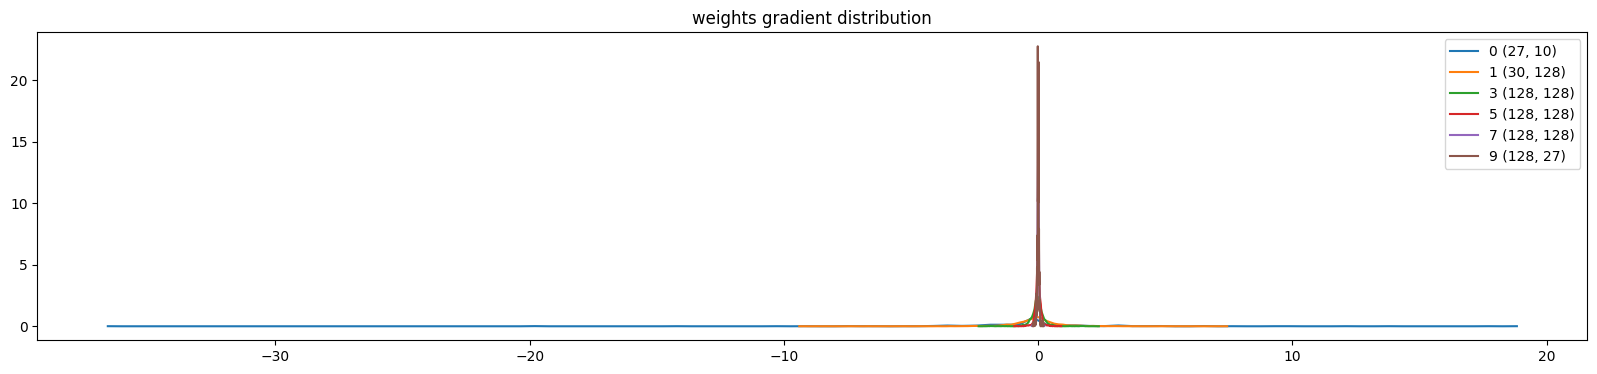

In [545]:
visualize_weights_gradients(model)

#### Weights gradients are not well distributed as well. Last layers have about 10 times bigger gradients, so they learn 10 times faster in the beginning

epoch=0: cur_avg_train_loss=14.489750367236802, cur_val_loss=12.0377836227417


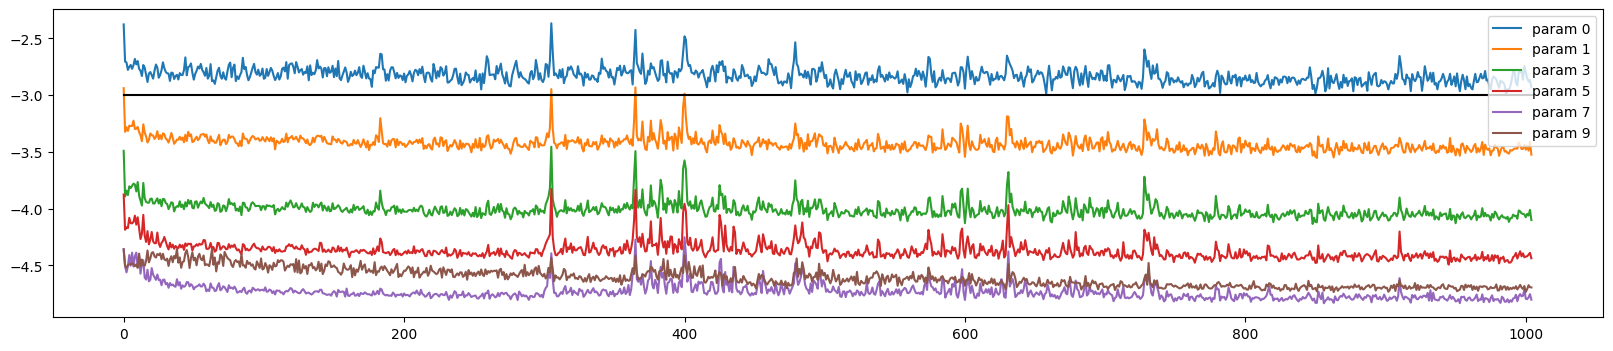

In [546]:
t_loss, v_loss = train2(model, train_ds, val_ds, epoches=1, batch_size=182, optimizer=optimizer)
visualize_gradient_to_weight_ratio(optimizer)

#### Last plot represents update to weight ratio in logarithmic scale. This ratio represents "how big is the value we use to change weight comparing with weight itself". Good value for that ratio is approx -3. Current plot shows at least 4 last parameters which have 10000 times smaller update value in comparison to weight value.

### Final training

In [547]:
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train2(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

model.nelement()=57257
init_t_loss=22.740550994873047, init_v_loss=22.746915817260742
epoch=0: cur_avg_train_loss=14.567042794360583, cur_val_loss=12.540712356567383
epoch=1: cur_avg_train_loss=11.574765436202881, cur_val_loss=10.912856101989746
epoch=2: cur_avg_train_loss=10.175031073064918, cur_val_loss=9.784379959106445
epoch=3: cur_avg_train_loss=9.236759615134433, cur_val_loss=9.026915550231934
epoch=4: cur_avg_train_loss=8.609389706436856, cur_val_loss=8.510573387145996
epoch=5: cur_avg_train_loss=8.1498530618698, cur_val_loss=8.123495101928711
epoch=6: cur_avg_train_loss=7.792167050904962, cur_val_loss=7.789858341217041
epoch=7: cur_avg_train_loss=7.457093098249094, cur_val_loss=7.4872517585754395
epoch=8: cur_avg_train_loss=7.190165700190571, cur_val_loss=7.254659175872803
epoch=9: cur_avg_train_loss=6.959921477800346, cur_val_loss=7.031979084014893
epoch=10: cur_avg_train_loss=6.750685651463816, cur_val_loss=6.839646816253662
epoch=11: cur_avg_train_loss=6.569610001556427, cur

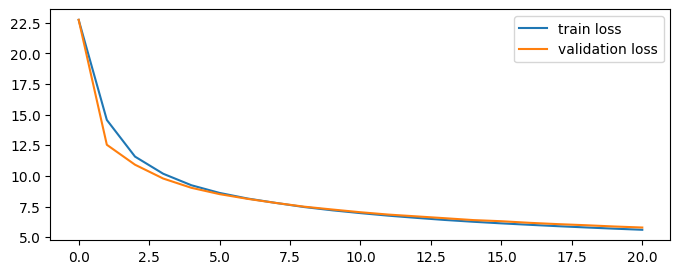

In [548]:
plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [549]:
for i in range(15):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

dgkemarnnlnfoi.
namase.
.
ysexdvljmyjsfel.
jetithqihgfkxadmflwdylcn.
gvcgwsvizuzeyan.
ysremiasqtvhgnlqilnzy.
herar.
hana.
euynphyzutladr.
mamiexiecn.
jumeldovmoqieter.
janely.
gvcgwyjsfeldzutbnagj.
nan.


In [550]:
with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(test_loss)

tensor(5.8005)
